In [3]:
import pandas as pd
db = pd.read_csv("combined_output.csv")
db.head(3)

,name,rating,time,comment,title
0,掉线,1,2016-06-08 02:37:32,【C-】我看过剪辑最烂的电影之一，不夸张地说剪辑水平几乎是小时代的级别，基本的剪辑点不对，基...,Warcraft
1,二月鸟语,2,2016-06-06 19:19:51,点映看两遍，看得昏昏欲睡，无聊至极。故事又老又俗套又狗血不说，故事都没讲明白，打来打去都没高...,Warcraft
2,rainmanyuan,2,2016-06-07 22:59:42,故事一般，特效凑合，排片量太大了，ume23:59居然排了8场，加上0点的，2点的午夜场一共...,Warcraft


In [8]:
imdb = pd.read_csv("imdb_combined_output.csv")
imdb

,title,comment,rating
0,Aquaman,"I rarely post reviews, but after watching this...",1
1,Aquaman,"SORRY JASON MAMOA, WE CANT LET AMBER HEARD RID...",1
2,Aquaman,"Too much water 0/10 ifi could give it that, if...",1
3,Aquaman,Oh seriously Amber Heard is the most untalente...,1
4,Aquaman,Very short review required Poor on all levels!...,1
...,...,...,...
1827,Zootopia,"After just seeing the movie with my friends, I...",4
1828,Zootopia,A cute female rabbit becomes a police officer ...,4
1829,Zootopia,"""I cordially dislike allegory in all its manif...",4
1830,Zootopia,"I know I'm in the minority here, but I just do...",4


In [9]:
comments = imdb["comment"].dropna().tolist()

In [36]:
from sentence_transformers import SentenceTransformer

# Use a multilingual model or a specific Chinese one
model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")
# For more accurate results with Chinese: "shibing624/text2vec-base-chinese"

embeddings = model.encode(comments, show_progress_bar=True)

Batches: 100%|██████████| 58/58 [00:50<00:00,  1.14it/s]


In [37]:
from sklearn.cluster import KMeans

num_clusters = 6  # tweak this
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
labels = kmeans.fit_predict(embeddings)

imdb['cluster'] = labels

In [39]:
for cluster_num in sorted(imdb['cluster'].unique()):
    print(f"\nCluster {cluster_num}:")
    #problem here where some of the clusters only have one comment in them
    sample_comments = imdb[imdb['cluster'] == cluster_num]['comment'].sample(4, random_state=42)
    for comment in sample_comments:
        print(" -", comment)


Cluster 0:
 - I'm so sick of the multiverse plot.

I'm convinced that a group of writers get together, take mushrooms, write down their trips, come back to reality, dump all their notes into a blender, hit "high" and pour out a steaming glass of ridiculous, confusing chaos.
 - I won't ever get those 2.5 hours of my life back. I would rather have spent then cleaning public toilets.

SFX equal to thay of Avatar and thay alone garnered two points.

Genuinely poor. I really hope nothing like this ever happens again. Ever.
 - Unreal, impossible, stupid, just too much sci-fi - it was so bad I stopped watching after 25 min
 - If you want to watch a super long Rick & Morty episode but with bad jokes instead (jokes in the style of the scary movies franchise) you might enjoy this rubbish. If that's not what you are looking for, don't waste your money or your time. Really really bad.

Cluster 1:
 - Ahoi cheesyness! This is as sugar sweet as it gets. So Disney! But if you're a fan, you will love 

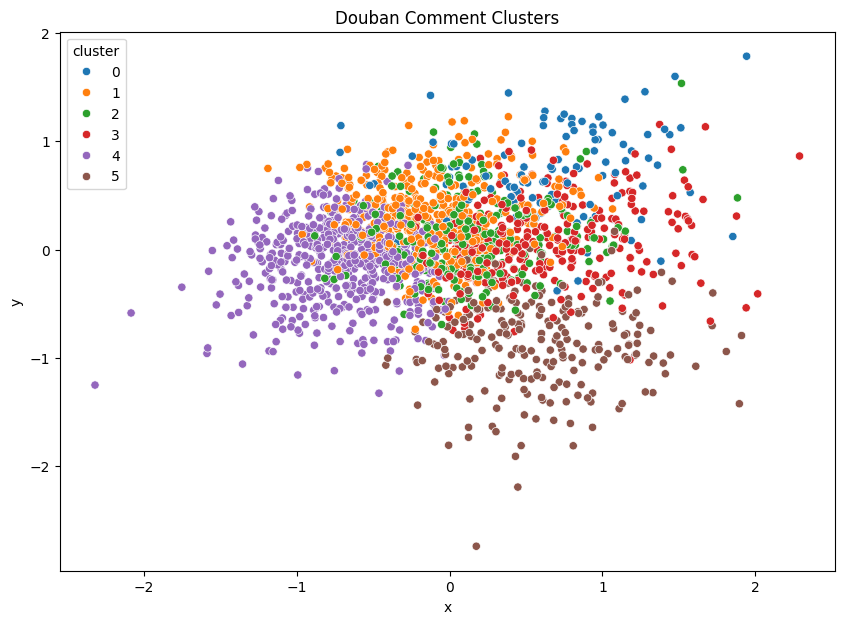

In [40]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

pca = PCA(n_components=2)
reduced = pca.fit_transform(embeddings)

imdb['x'] = reduced[:, 0]
imdb['y'] = reduced[:, 1]

plt.figure(figsize=(10, 7))
sns.scatterplot(data=imdb, x='x', y='y', hue='cluster', palette='tab10')
plt.title("Douban Comment Clusters")
plt.show()

In [41]:
from keybert import KeyBERT

kw_model = KeyBERT(model)
for i in range(num_clusters):
    cluster_comments = imdb[imdb['cluster'] == i]['comment'].tolist()
    joined = " ".join(cluster_comments)
    keywords = kw_model.extract_keywords(joined, top_n=10)
    print(f"Cluster {i} keywords:", keywords)

Cluster 0 keywords: [('cast', 0.4292), ('storyline', 0.4169), ('protagonists', 0.4032), ('episode', 0.3836), ('protagonisti', 0.3746), ('actors', 0.3737), ('actor', 0.3702), ('protagonist', 0.3578), ('screenplay', 0.3537), ('actress', 0.3512)]
Cluster 1 keywords: [('villains', 0.4311), ('comedies', 0.4232), ('actors', 0.4222), ('portrayed', 0.4214), ('starring', 0.4129), ('cinematic', 0.4126), ('blockbusters', 0.4078), ('fangirls', 0.407), ('comic', 0.4051), ('villain', 0.4029)]
Cluster 2 keywords: [('cinematic', 0.539), ('cinematics', 0.5233), ('cinematographic', 0.5027), ('moviegoer', 0.5), ('filmmaking', 0.4991), ('cinematography', 0.4909), ('films', 0.474), ('movie', 0.4718), ('filmmakers', 0.4695), ('film', 0.4619)]
Cluster 3 keywords: [('actress', 0.4588), ('heroine', 0.4536), ('supergirl', 0.4234), ('actresses', 0.3999), ('starring', 0.3903), ('starred', 0.3894), ('draka', 0.3808), ('martha', 0.3778), ('bayona', 0.3703), ('fan', 0.3679)]
Cluster 4 keywords: [('moviegoers', 0.492

In [ ]:
imdb['comment'].str.contains('heroine')

np.int64(4)

In [50]:
imdb[imdb['cluster'] == 3][imdb[imdb['cluster'] == 3]['comment'].str.contains('heroine')]['comment']

994     ***** spoilers *****\n\nwatched Jurassic world...
1188    The novel kind of tired me out; even though I ...
Name: comment, dtype: object

In [51]:
imdb['cluster'].value_counts()

cluster
4    517
1    428
3    282
2    253
5    235
0    117
Name: count, dtype: int64

In [52]:
imdb[['title', 'cluster']].value_counts().unstack()

cluster,0,1,2,3,4,5
title,,,,,,
Aquaman,11.0,21.0,10.0,12.0,26.0,20.0
Avatar,1.0,23.0,36.0,13.0,26.0,NaN
Avatar: The Way of Water,6.0,26.0,33.0,14.0,21.0,NaN
Avengers: Age of Ultron,8.0,9.0,9.0,15.0,19.0,40.0
Avengers: Endgame,5.0,8.0,9.0,15.0,22.0,40.0
Avengers: Infinity War,10.0,16.0,4.0,18.0,17.0,34.0
Everything Everywhere All at Once,8.0,45.0,2.0,4.0,40.0,1.0
Fast & Furious Presents: Hobbs & Shaw,13.0,20.0,3.0,31.0,33.0,NaN
Furious 7,2.0,32.0,3.0,17.0,43.0,3.0


In [21]:
imdb['title'].value_counts()

title
Aquaman                                  100
Avatar: The Way of Water                 100
Avengers: Age of Ultron                  100
Venom                                    100
Transformers: The Last Knight            100
Everything Everywhere All at Once        100
Fast & Furious Presents: Hobbs & Shaw    100
Furious 7                                100
Transformers: Age of Extinction          100
Jurassic World: Fallen Kingdom           100
Ready Player One                         100
The Fate of the Furious                   99
Jurassic World                            99
Spider-Man: Far From Home                 99
Avatar                                    99
Avengers: Infinity War                    99
Avengers: Endgame                         99
Warcraft                                  93
Zootopia                                  45
Name: count, dtype: int64